<a href="https://colab.research.google.com/github/LCaravaggio/NLP/blob/main/03_redes/FeedForwardNN_para_Clasificaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

La Notebooke original es esta:
https://www.kaggle.com/code/jvdahemad/twitter-sentiment-analysis-using-text-embedding/notebook

La original tiene más cosas que puede estar interesante mirar, pero ojo que tiene algunos errores.

# Carga de datos

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kazanova/sentiment140

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Mounted at /content/drive
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

In [30]:
import numpy as np
import random
import pandas as pd
import re
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import tensorflow as tf

In [31]:
n = 1600000 #number of records in file
s = 100000 #desired sample size
filename = "/content/training.1600000.processed.noemoticon.csv"
skip = sorted(random.sample(range(n),n-s))

data = pd.read_csv(filename, skiprows=skip, header=None,engine='python',encoding='latin1')

data.columns=['Sentiment','Id','Date','Query','User','Text']
train_data=data.iloc[:,-1].values
train_label=data.iloc[:,0].values

In [32]:
stemmer=SnowballStemmer('english')

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
stopwords = stopwords.words('english')

def tweet_clean(tweet):
    tweet=re.sub(r'@[A-Za-z0-9]+'," ",tweet) ##Removing the usernames
    tweet=re.sub(r'^[A-Za-z0-9.!?]+'," ",tweet) ##Removing digits and punctuations
    tweet=re.sub(r'https?://[A-Za-z0-9./]+'," ",tweet) ## removing links
    tweet=re.sub(r' +'," ",tweet)
    tweet = tweet.lower()
    tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    tweet = re.sub(r"can't", "cannot ", tweet)
    tweet = re.sub(r"n't", " not ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)
    tweet = re.sub(r"\'scuse", " excuse ", tweet)
    tweet = tweet.strip(' ')
    tweet = tweet.strip('. .')
    tweet = tweet.replace('.',' ')
    tweet = tweet.replace('-',' ')
    tweet = tweet.replace("’", "'").replace("′", "'").replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")
    tweet = tweet.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")
    tweet = tweet.replace("€", " euro ").replace("'ll", " will")
    tweet = tweet.replace("don't", "do not").replace("didn't", "did not").replace("im","i am").replace("it's", "it is")
    tweet = tweet.replace(",000,000", "m").replace("n't", " not").replace("what's", "what is")
    tweet = tweet.replace(",000", "k").replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")
    tweet = tweet.replace("he's", "he is").replace("she's", "she is").replace("'s", " own")
    tweet = re.sub('\s+', ' ', tweet)
    tweet=tweet.split()
    tweet=[stemmer.stem(word) for word in tweet if word not in stopwords]
    tweet=' '.join(word for word in tweet)


    return tweet.lower()

tweets_clean=[tweet_clean(tweet) for tweet in train_data]

In [35]:
data['Text_clean']=tweets_clean
data['No_of_Words']=[len(text.split()) for text in data['Text_clean']]

In [36]:
train_label[train_label==4]=1  ##Resetting the labels for positive tweets to 1

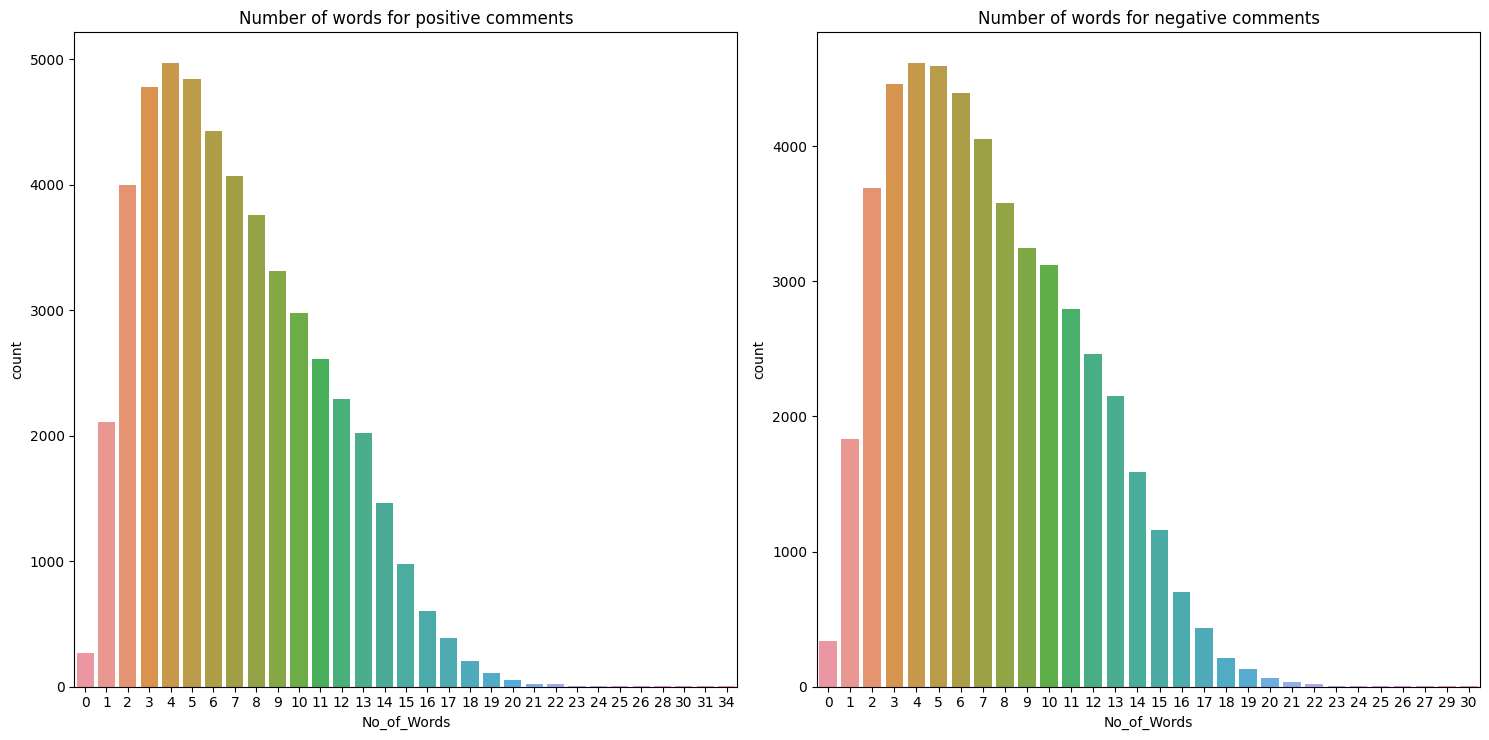

In [37]:
negatives=data['Sentiment']==0
positives=data['Sentiment']==1
fig,ax =plt.subplots(nrows=1,ncols=2,figsize=(15,7.5))

sns.countplot(x=data[positives]['No_of_Words'],label='Positive',ax=ax[0])
sns.countplot(x=data[negatives]['No_of_Words'],label='Negative',ax=ax[1])
ax[0].set_title('Number of words for positive comments')
ax[1].set_title('Number of words for negative comments')
plt.tight_layout()
plt.show()

# Tokenización

In [38]:
import tensorflow_datasets as tfds

# Build the tokenizer from your corpus
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    tweets_clean, target_vocab_size=2**16
)

# Save the tokenizer to a file for later use
tokenizer.save_to_file('tokenizer_tweets')

# Encode your data using the tokenizer
data_inputs = [tokenizer.encode(sentence) for sentence in tweets_clean]

In [39]:
Max_len=np.max([len(sentence) for sentence in data_inputs])

### Padding with 0s at the end of the sentences since 0 has no value and it wouldn't change the meaning of our sentence
data_inputs=tf.keras.preprocessing.sequence.pad_sequences(data_inputs,value=0,padding='post',maxlen=Max_len)

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_inputs, train_label, test_size=0.5, random_state=42)

In [54]:
import tensorflow as tf

class SimpleFeedForwardNN(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 FFN_units=256,
                 nb_classes=2,
                 dropout_rate=0.1,
                 name='simple_ffnn'):
        super(SimpleFeedForwardNN, self).__init__(name=name)

        self.embeddings = tf.keras.layers.Embedding(vocab_size, emb_dim)
        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(units=FFN_units, activation='relu')
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

        if nb_classes == 2:
            self.dense_2 = tf.keras.layers.Dense(units=1, activation='sigmoid')
        else:
            self.dense_2 = tf.keras.layers.Dense(units=nb_classes, activation='softmax')

    def call(self, inputs, training):
        x = self.embeddings(inputs)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dropout(x, training)
        output = self.dense_2(x)

        return output

In [55]:
VOCAB_SIZE = tokenizer.vocab_size

EMB_DIM = 100
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))

DROPOUT_RATE = 0.2

BATCH_SIZE = 256
NB_EPOCHS = 1

In [56]:
SimpleFeedForwardNN = SimpleFeedForwardNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    SimpleFeedForwardNN.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    SimpleFeedForwardNN.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [57]:
checkpoint_path = "/content/"

ckpt = tf.train.Checkpoint(SimpleFeedForwardNN=SimpleFeedForwardNN)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

In [58]:
SimpleFeedForwardNN.fit(X_train,
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

196/196 [==============================] - 61s 303ms/step - loss: 0.6852 - accuracy: 0.5493


# Glove

In [62]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-09-06 19:04:57--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-09-06 19:04:58--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.10MB/s    in 2m 39s  

2023-09-06 19:07:37 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [66]:
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [68]:
import codecs
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/content/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 400000 word vectors


In [100]:
vocabulary = data_inputs
emb_dim=100

vocab_size = tokenizer.vocab_size
embedding_dim = 100  # Use the appropriate dimension for your GloVe embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill the embedding matrix with GloVe embeddings
for index in range(vocab_size):
    word = tokenizer.decode([index]).replace(' ', '')  # Decode the subword to get the full word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words found in GloVe embeddings
        embedding_matrix[index] = embedding_vector

In [102]:
embedding_matrix.shape

(64272, 100)

In [103]:
import tensorflow as tf
import numpy as np

class SimpleFeedForwardNN(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 FFN_units=256,
                 nb_classes=2,
                 dropout_rate=0.1,
                 embedding_matrix=None,  # Pass the embedding matrix here.
                 name='simple_ffnn'):
        super(SimpleFeedForwardNN, self).__init__(name=name)

        if embedding_matrix is not None:
            self.embeddings = tf.keras.layers.Embedding(
                input_dim=vocab_size,
                output_dim=emb_dim,
                weights=[embedding_matrix],  # Use the pre-trained embedding matrix.
                trainable=False  # Freeze the embeddings.
            )
        else:
            self.embeddings = tf.keras.layers.Embedding(vocab_size, emb_dim)

        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(units=FFN_units, activation='relu')
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

        if nb_classes == 2:
            self.dense_2 = tf.keras.layers.Dense(units=1, activation='sigmoid')
        else:
            self.dense_2 = tf.keras.layers.Dense(units=nb_classes, activation='softmax')

    def call(self, inputs, training):
        x = self.embeddings(inputs)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dropout(x, training)
        output = self.dense_2(x)

        return output

In [105]:
SimpleFeedForwardNN = SimpleFeedForwardNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    SimpleFeedForwardNN.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    SimpleFeedForwardNN.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [106]:
SimpleFeedForwardNN.fit(X_train,
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

196/196 [==============================] - 64s 317ms/step - loss: 0.6135 - accuracy: 0.6560


Glove Not frezzed

In [108]:
class SimpleFeedForwardNN(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 FFN_units=256,
                 nb_classes=2,
                 dropout_rate=0.1,
                 embedding_matrix=None,  # Pass the embedding matrix here.
                 name='simple_ffnn'):
        super(SimpleFeedForwardNN, self).__init__(name=name)

        if embedding_matrix is not None:
            self.embeddings = tf.keras.layers.Embedding(
                input_dim=vocab_size,
                output_dim=emb_dim,
                weights=[embedding_matrix],  # Use the pre-trained embedding matrix.
                trainable=True  # DONT Freeze the embeddings.
            )
        else:
            self.embeddings = tf.keras.layers.Embedding(vocab_size, emb_dim)

        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(units=FFN_units, activation='relu')
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

        if nb_classes == 2:
            self.dense_2 = tf.keras.layers.Dense(units=1, activation='sigmoid')
        else:
            self.dense_2 = tf.keras.layers.Dense(units=nb_classes, activation='softmax')

    def call(self, inputs, training):
        x = self.embeddings(inputs)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dropout(x, training)
        output = self.dense_2(x)

        return output

In [109]:
SimpleFeedForwardNN = SimpleFeedForwardNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    SimpleFeedForwardNN.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    SimpleFeedForwardNN.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [110]:
SimpleFeedForwardNN.fit(X_train,
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

196/196 [==============================] - 59s 296ms/step - loss: 0.6401 - accuracy: 0.6277
